In [1]:
!pip install -q torch torchvision torchaudio
!pip install -q transformers datasets accelerate Pillow huggingface_hub

In [2]:
import os
import json
import torch
import torch.nn as nn
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from transformers import CLIPVisionModel, AutoImageProcessor
from datasets import load_dataset
from huggingface_hub import snapshot_download

In [3]:
import torch
import matplotlib.pyplot as plt
from transformers import AutoProcessor, AutoModelForImageTextToText
from datasets import load_dataset
import random

model_id = "unsloth/medgemma-4b-it"
device = "cuda" if torch.cuda.is_available() else "cpu"

print(f"Loading model on {device}...")
processor = AutoProcessor.from_pretrained(model_id)
model = AutoModelForImageTextToText.from_pretrained(
    model_id,
    torch_dtype=torch.bfloat16 if device == "cuda" else torch.float32
).to(device)


Loading model on cuda...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
`torch_dtype` is deprecated! Use `dtype` instead!


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [7]:

print("Loading dataset...")
dataset = load_dataset('flaviagiammarino/vqa-rad', split='train', streaming=False)


Loading dataset...


In [8]:

def run_inference_and_show(idx):
    item = dataset[idx]
    image = item['image'].convert("RGB")
    question = item['question']
    ground_truth = item['answer']

    messages = [
        {
            "role": "user",
            "content": [
                {"type": "text", "text": question},
                {"type": "image", "image": image}
            ]
        }
    ]

    text_prompt = processor.apply_chat_template(messages, add_generation_prompt=True)

    inputs = processor(
        text=text_prompt,
        images=image,
        return_tensors="pt"
    ).to(device)

    with torch.no_grad():
        outputs = model.generate(**inputs, max_new_tokens=50)

    generated_text = processor.decode(
        outputs[0][inputs["input_ids"].shape[-1]:],
        skip_special_tokens=False
    )

    plt.figure(figsize=(8, 8))
    plt.imshow(image)
    plt.axis('off')

    result_text = (
        f"Question: {question}\n"
        f"Ground Truth: {ground_truth}\n"
        f"Model Prediction: {generated_text}"
    )

    plt.title(result_text, fontsize=12, loc='left', wrap=True)
    plt.tight_layout()
    plt.show()


Running inference examples...


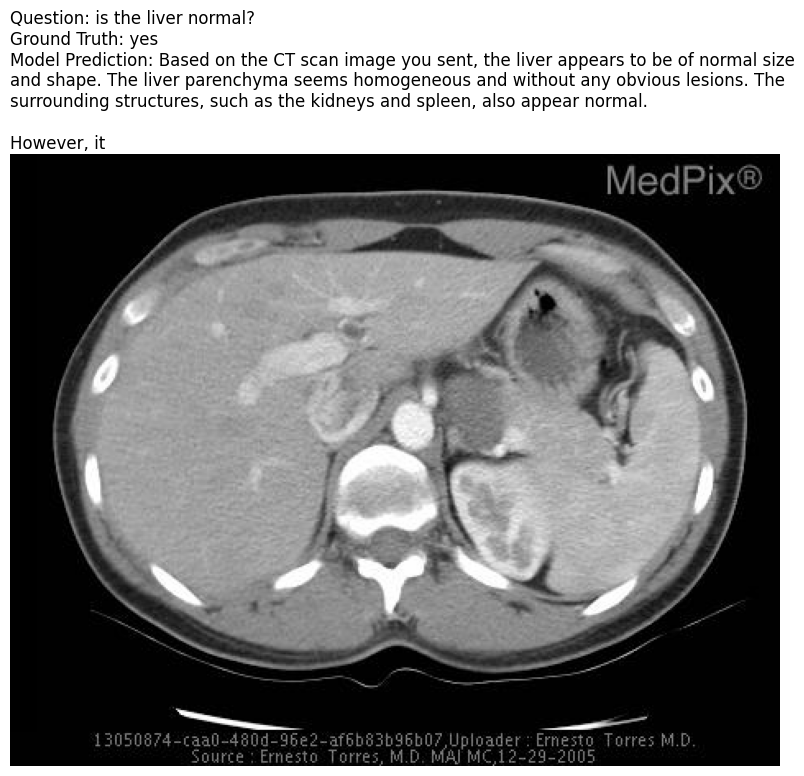

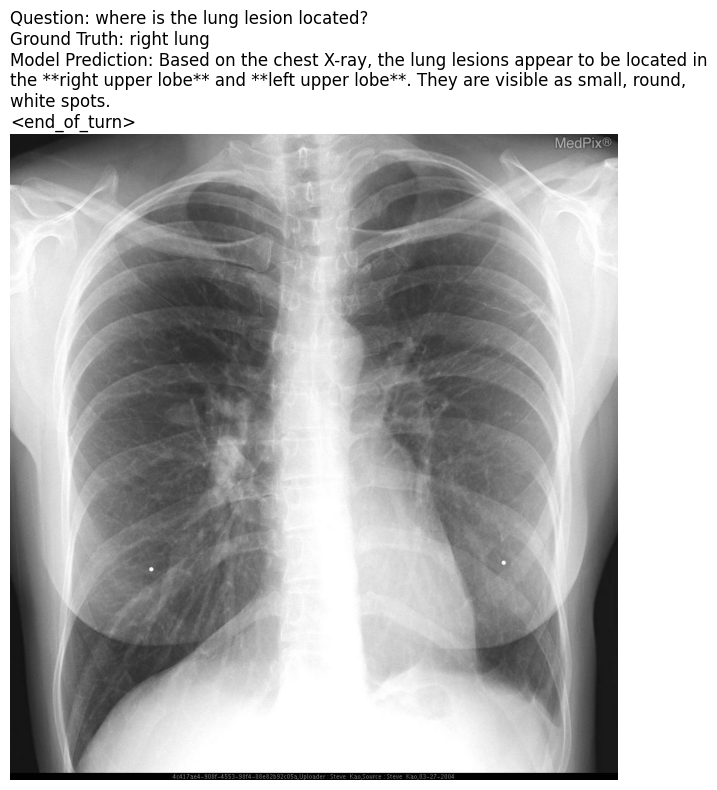

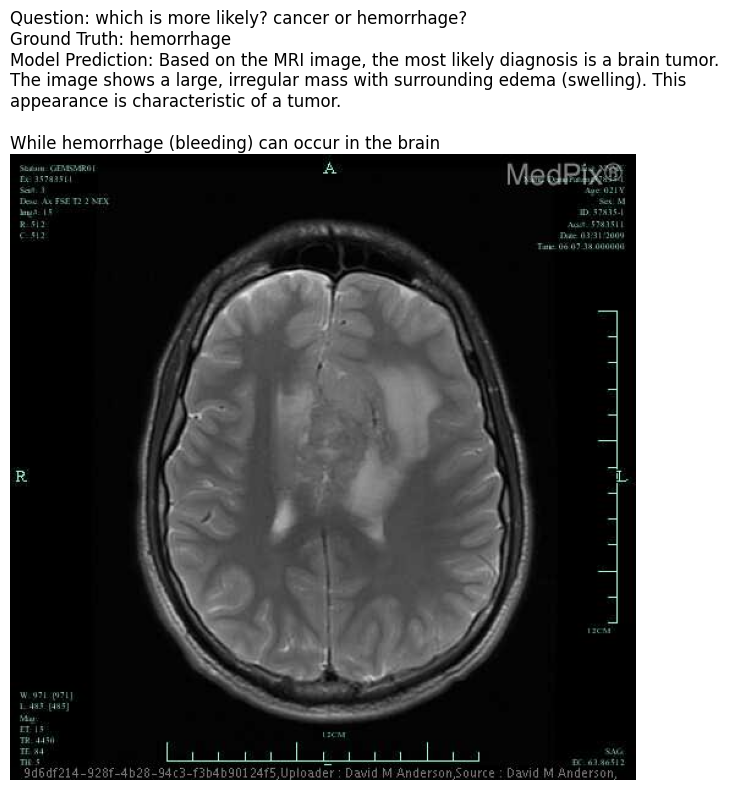

In [9]:

indices = random.sample(range(len(dataset)), 3)

for idx in indices:
    run_inference_and_show(idx)